# Exploration of the Embeddings

The embeddedings were created using the embedding API by openai. 
The strings comprised of the dataset title, description, and long
description (or whatever data there was available from those 
categories).

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.decomposition import PCA

In [ ]:
# Import embeddings (done on the strings created for each dataset) and performing mean normalisation
embeddings_df = pd.read_json('~/database_compendium/data/final_embeddings.json')
normalised_df = (embeddings_df-embeddings_df.mean())/embeddings_df.std()

In [ ]:
# Performing PCA keeping at least 80% of the explained variance
pca = PCA(n_components=73)
cols = ['PC' + str(i) for i in range(73)]
principalComponents = pca.fit_transform(normalised_df.T)
principal_df = pd.DataFrame(principalComponents, columns=cols)

explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)
cum_var = round(max(cumulative_var_ratio)*100, 1)
print(f"The principal components explain {cum_var}% of the variance")

The principal components explain 80.2% of the variance


In [ ]:
# Adding the dataset titles back after PCA
principal_df.insert(0, 'Dataset_title', list(embeddings_df.columns))
principal_df.head(3)

,Dataset_title,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72
0,Quarterly personal well-being estimates,6.663733,0.048016,3.370242,4.024503,0.225782,2.551249,0.463104,-3.311750,-1.934044,...,0.262786,1.670976,-1.011120,0.275283,2.904163,0.236773,1.942440,1.676887,0.702487,-1.237450
1,Personal well-being estimates by local authority,6.755539,0.300209,3.718559,3.469152,-0.125358,2.784452,0.447448,-3.485710,-1.972821,...,0.577211,1.084180,-0.684288,1.153666,2.741332,-0.312322,1.534295,1.761335,1.218562,-1.659709
2,Deaths registered weekly in England and Wales ...,9.521175,-1.462629,3.615774,2.398188,-0.797274,0.828975,1.372468,-0.354584,-3.900317,...,-0.425880,1.815007,1.394769,-1.468552,-0.324833,-0.630915,1.877824,0.221605,1.733563,-2.209332


In [ ]:
# Plotting the data in terms of the first two principal components
fig = px.scatter(principal_df, 
                 x='PC0', y='PC1', 
                 hover_data={'Title': list(principal_df.iloc[:, 0])})

fig.layout.height = 500
fig.show()

## Data Similarity
Using cosine similarity and SVM to calculate the similarity between datasets.

In [ ]:
#| export
def cos_similarity(data, # Dataset as a dataframe that we want to use to compare rows
                   compare_row=0, # The row in the dataset that will be compared with all the others
                   num=10): # The number of similar datasets that will be returned (in descending order)

    """Using cosine similarity to find the most closely related datasets"""

    if type(data.iloc[0, 0]) == str:
        labels = data.iloc[:, 0]
        vectors = data.iloc[:, 1:]
    else:
        labels = data.index.values
        vectors = data.iloc[:, :]
        
    query = vectors.iloc[compare_row, :].values
    vectors = vectors.drop(compare_row).values
    
    """ 
    Calculate the cosine similarity between the query vector and each embedding vector
    and sort in descending order.
    
    https://github.com/karpathy/randomfun/blob/master/knn_vs_svm.ipynb
    """
    similarities = vectors.dot(query)
    sorted_ix = np.argsort(-similarities)
                           
    updated_labels = labels
    del updated_labels[compare_row]
    updated_labels = list(updated_labels)

    return [updated_labels[i] for i in sorted_ix[:num]], similarities[sorted_ix[:num]]

In [ ]:
compare_row = 0
labels, similarity = cos_similarity(principal_df, compare_row=compare_row)

print(f"Top 10 datasets similar to \n{principal_df.iloc[compare_row, 0]}: \n")
for k in range(len(labels)):
    print(f"{labels[k]}, similarity {round(similarity[k])}")

Top 10 datasets similar to 
Quarterly personal well-being estimates: 

Personal well-being estimates by local authority, similarity 247
Life Expectancy by Local Authority, similarity 173
Local authority ageing statistics, older people economic activity, similarity 171
UK Labour Market, similarity 171
GDP monthly estimate (incorporating the Index of Services and Index of Production), similarity 168
Expenditure on healthcare: UK Health Accounts, similarity 166
labour force survey - quarterly: four quarter averages, similarity 160
Deaths registered weekly in England and Wales by region, similarity 160
Quarterly GDP for England, Wales and the English regions, similarity 153
Annual GDP for England, Wales and the English regions, similarity 152


In [ ]:
#| export
def svm_similarity(data, # Dataset as a dataframe that we want to use to compare rows
                   compare_row=0, # The row in the dataset that will be compared with all the others
                   num=10): # The number of similar datasets that will be returned (in descending order)

    """Using SVM to find the most closley related datasets"""

    from sklearn import svm
    
    if type(data.iloc[0, 0]) == str:
        labels = data.iloc[:, 0]
        vectors = data.iloc[:, 1:]
    else:
        labels = data.index.values
        vectors = data.iloc[:, :]
    
    target = np.zeros(len(vectors))
    target[compare_row] = 1
    
    clf = svm.LinearSVC(class_weight='balanced', verbose=False, 
                        max_iter=10000, tol=1e-6, C=1)
    clf.fit(vectors, target)
    
    similarities = clf.decision_function(vectors)
    sorted_ix = np.argsort(-similarities)
    
    updated_labels = labels
    del updated_labels[compare_row]
    updated_labels = list(updated_labels)
    
    return [updated_labels[i] for i in sorted_ix[:num]], similarities[sorted_ix[:num]]

In [ ]:
labels, similarity = svm_similarity(principal_df, compare_row=0)

print(f"Top 10 datasets similar to \n{principal_df.iloc[compare_row, 0]}: \n")
for k in range(len(labels)):
    print(f"{labels[k]}, similarity {round(similarity[k], 4)}")

Top 10 datasets similar to 
Quarterly personal well-being estimates: 

Personal well-being estimates by local authority, similarity 0.9993
Deaths registered weekly in England and Wales by region, similarity -0.0866
benefit claimants - employment and support allowance for small areas, similarity -0.8645
QS603EW - Economic activity - Full-time students, similarity -0.8908
DC3602EW - Long-term health problem or disability by NS-SeC by sex by age, similarity -0.9055
annual population survey - workplace analysis, similarity -0.9142
QS105EW - Schoolchildren and full-time students at their non term-time address, similarity -0.9144
2001 census - census area statistics theme tables, similarity -0.9284
Table 6: Self-employed bankruptcies by industry (2-level Standard Industrial Classification), England and Wales [p][note 6][note 10][note 11], similarity -0.9425
Gender identity by occupation, similarity -0.9446


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

## Clustering

In [ ]:
#| hide
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

### K-Means Clustering
Performing K-Means clustering and showing 3 of the clusters.

In [ ]:
vectors = principal_df.iloc[:, 1:]
vectors = np.vstack(vectors.values)

In [ ]:
# The number of clusters was picked following evaluation of various models using the sum of squares error
kmeans = KMeans(n_clusters=40, init='k-means++', n_init=10, random_state=42)
kmeans.fit(vectors)
cluster_labels = kmeans.labels_

In [ ]:
vectors_labelled = principal_df
vectors_labelled['Cluster'] = list(cluster_labels)

# Picking a few clusters so they are more easily distinguished
clusters = vectors_labelled.loc[(vectors_labelled.loc[:,'Cluster'] == 5) | 
                               (vectors_labelled.loc[:,'Cluster'] == 10) |
                               (vectors_labelled.loc[:,'Cluster'] == 15)]

fig = px.scatter(clusters, 
                 x='PC0', y='PC1', 
                 hover_data={'Title': list(clusters.iloc[:, 0])},
                 color='Cluster',
                 color_continuous_scale=px.colors.sequential.Rainbow)

fig.update(layout_coloraxis_showscale=False)
fig.layout.height = 500
fig.show()

### Hierarchical Clustering

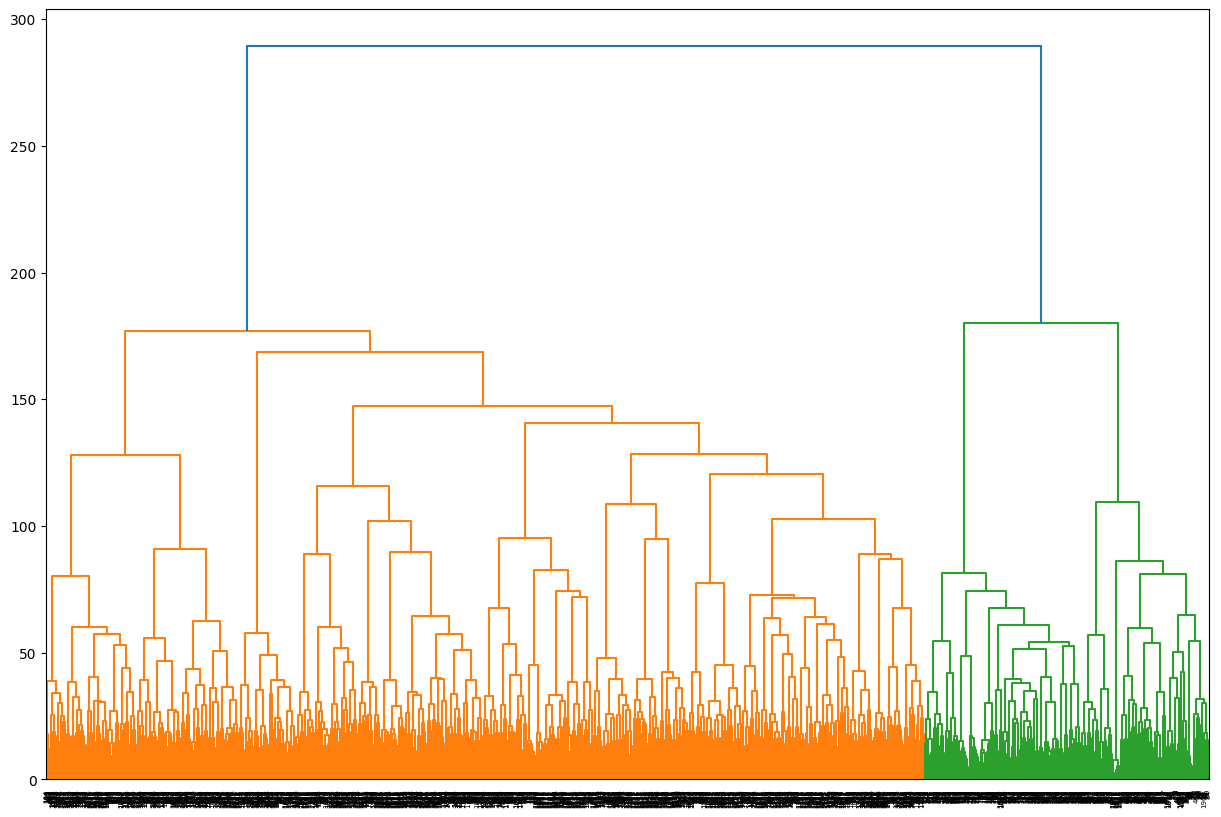

In [ ]:
"""
Dendrogram analysis

Compute the linkage matrix and plot a dendrogram.
"""
plt.figure(figsize=(15,10))
dend = shc.dendrogram(shc.linkage(vectors, method='ward'))
plt.show()

In [ ]:
# The number of clusters was picked following evaluation of various models using the silhouette score
cluster = AgglomerativeClustering(n_clusters=34, linkage='ward')
cluster.fit(vectors)
c_labels = cluster.labels_

In [ ]:
vs_labelled = principal_df
vs_labelled['Cluster'] = list(c_labels)

# Picking a few clusters so they are more easily distinguished
test = vs_labelled.loc[(vs_labelled.loc[:,'Cluster'] == 0) | 
                       (vs_labelled.loc[:,'Cluster'] == 5) |
                       (vs_labelled.loc[:,'Cluster'] == 10)]

fig = px.scatter(test, 
                 x='PC0', y='PC1', 
                 hover_data={'Title': list(test.iloc[:, 0])},
                 color='Cluster',
                 color_continuous_scale=px.colors.sequential.Rainbow)

fig.layout.height = 500
fig.show()

## Plotting the Datasets on a Network Diagram

In [ ]:
"""
Creating a dataframe to be used to make a network diagram.

To do this we:
 - Go through every dataset
 - Get a list of the similarity between each dataset and every other dataset

The dataframe has a source, target, and weight columns. The similarity between the source and 
the target is the weight.
"""
network_df = pd.DataFrame(columns=['Source', 'Target', 'weight'])

for i in range(len(principal_df)):

    labels = list(principal_df.iloc[:, 0].values)
    ls, s_values = cos_similarity(principal_df, i, num=len(principal_df))

    s_values = (s_values - min(s_values))/(max(s_values) - min(s_values)) #* 3
    
    source_labels = [labels[i]] * len(s_values)
    updated_labels = labels
    del updated_labels[i]
    updated_labels = list(updated_labels)

    temp_df = pd.DataFrame({'Source': source_labels, 'Target': updated_labels, 'weight': s_values})
    temp_df = temp_df.sort_values(by='weight', ascending=False)[:5] # taking top 5 most similar datasets to the one being compared
    network_df = pd.concat([network_df, temp_df]).reset_index(drop=True)

#### A histogram of the weights.

In [ ]:
fig = px.histogram(network_df, x='weight', nbins=50)
fig.layout.height = 500
fig.show()

#### A network diagram using plotly

In [ ]:
#| hide
import networkx as nx
import plotly.graph_objects as go

In [ ]:
# Random sample (of the top 5 most similar datasets for each dataset)
new_data = network_df.sample(1000) 

G = nx.from_pandas_edgelist(new_data,
                            source='Source',
                            target='Target',
                            edge_attr='weight')

node_sizes = [min(len(list(G.edges(node)))*2, 10) for node in G.nodes()]

# Set the positions of the nodes
pos = nx.spring_layout(G)

# Create a list to store the edge traces
edge_traces = []

# Create an edge trace for each edge with varying width
for u, v, d in G.edges(data=True):
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    width = d['weight']
        
    edge_trace = go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        line=dict(width=width, color='gray'),
        hoverinfo='none',
        mode='lines'
    )
    
    edge_traces.append(edge_trace)

# Create a node trace
node_trace = go.Scatter(
    x=[pos[node][0] for node in G.nodes()],
    y=[pos[node][1] for node in G.nodes()],
    text=[node for node in G.nodes()],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color='blue',
        size=node_sizes # The size of the node depends on the number of edges connected to it
    )
)

# Create the network graph figure
fig = go.Figure(data=edge_traces + [node_trace],
                layout=go.Layout(
                    title='',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                )
            )

# Display the network graph
fig.layout.height = 750
fig.show()

#### A network diagram using pyvis

In [ ]:
#| hide
from pyvis.network import Network
from IPython.display import display

In [ ]:
net = Network(notebook=True)
net.from_nx(G)
net.show('network.html')

network.html
